In [1]:
import SimpleITK as sitk
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Load the CSV file
csv_path = "/kaggle/input/dataset-csv/dataset_lung.xlsx"
data = pd.read_excel(csv_path)

data.head()

,Full_slice,Nodule,TumorClass
0,pat1_fullslice.nrrd,pat1_nodule.nrrd,5
1,pat2_fullslice.nrrd,pat2_nodule.nrrd,5
2,pat3_fullslice.nrrd,pat3_nodule.nrrd,2
3,pat4_fullslice.nrrd,pat4_nodule.nrrd,5
4,pat5_fullslice.nrrd,pat5_nodule.nrrd,4


In [2]:
def load_nrrd(file_path):
    """Load an NRRD file using SimpleITK."""

    train_loc = '/kaggle/input/test-dataset/Train'
    
    file_path = os.path.join(train_loc, file_path)
    image = sitk.ReadImage(file_path)
    array = sitk.GetArrayFromImage(image)  # Convert to NumPy array
    # print(np.min(array), np.max(array))
    return array

In [3]:
data_loaded = False
if not data_loaded:
    images = data['Full_slice']
    images = images.apply(load_nrrd)

    nodules = data['Nodule']
    nodules = nodules.apply(load_nrrd)

    labels = data['TumorClass']
    
    print(images[0].shape, nodules[0].shape)
    print(images[1].shape, nodules[1].shape)
    print(images[2].shape, nodules[2].shape)
    print(images[3].shape, nodules[3].shape)

    np.savez("new_dataset", images=images, labels=labels, nodules=nodules)
    
else:
    path = ''
    data = np.load(path)
    images = data['images']
    labels = data['labels']
    nodules = data['nodules']

(512, 512) (84, 92)
(512, 512) (90, 85)
(512, 512) (74, 76)
(512, 512) (85, 80)


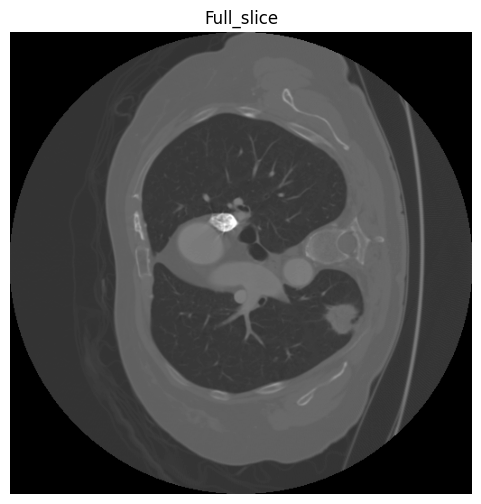

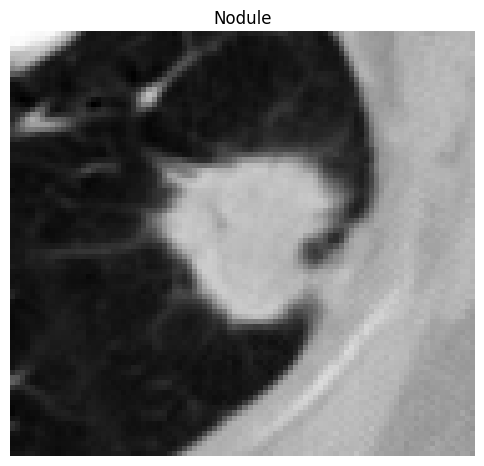

In [4]:
def visualize_image(image, title="Image"):
    """Visualize a 2D image."""
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Visualize full slice and nodule
visualize_image(images[0], title="Full_slice")
visualize_image(nodules[0], title="Nodule")


In [5]:
from skimage.feature import match_template

def locate_template(image, template):
    # Perform template matching
    result = match_template(image, template)
    
    # Find the location with the highest match score
    ij = np.unravel_index(np.argmax(result), result.shape)
    y, x = ij

    return x, y

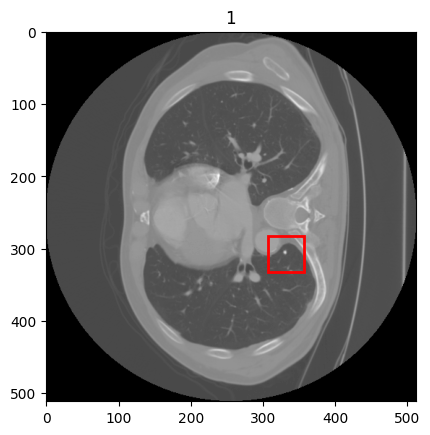

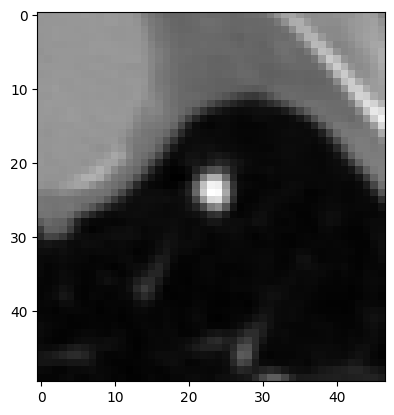

In [6]:
import matplotlib.patches as patches


x, y = locate_template(images[30], nodules[30])
fig, axis = plt.subplots()
plt.title(labels[30])
axis.imshow(images[30], cmap='gray')
r = patches.Rectangle((x, y), nodules[30].shape[0], nodules[30].shape[0], linewidth=2, edgecolor='r', facecolor='none')
axis.add_patch(r)
plt.figure()
plt.imshow(nodules[30], cmap='gray')

In [7]:
from collections import Counter
label_counts = Counter(labels)
print(label_counts)

Counter({3: 1092, 2: 457, 4: 418, 1: 244, 5: 152})


The dataset is highly unbalanced, so we should balance it

# **EDA Full Images**

### Image size and values range

In [8]:
images.apply(lambda im: im.shape).unique()

array([(512, 512)], dtype=object)

In the following script we clearly see that all full images have shape 512x512, so the reshaping to 224x224 is only due to the ResNet50 requirements1.

Type of the image:  int16
Value range is:  [-2048, 3071]


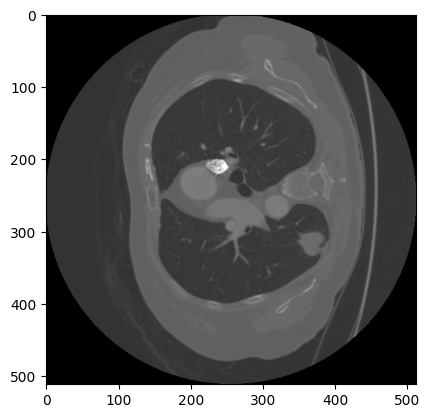

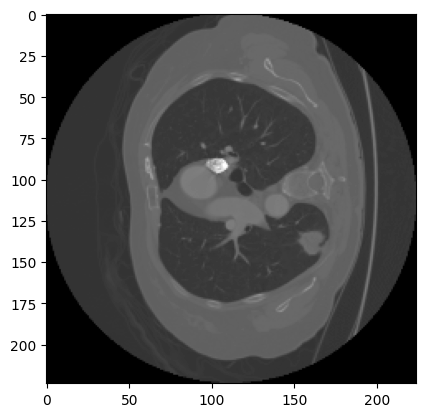

In [9]:
import cv2

new_shape = (224, 224)
print("Type of the image: ", images[0].dtype) # the type
print("Value range is: ", [np.min(images[0]), np.max(images[0])])
plt.imshow(images[0], cmap='gray')
plt.figure()
plt.imshow(cv2.resize(images[0], new_shape), cmap='gray')

It is also possible to notice that the image is not a classical png/jpg image (3 channels - [0 - 255] range; uint16), but a nrrd one, whose values represent the Hunsfield values (HU) and are encoded as signed int16.

Since we are going to use ResNet50 to train the models, we shall use classical images in input. In order to do so, we will apply a window to each image, to extract the LUNG range of the HU values

0.0 255.0


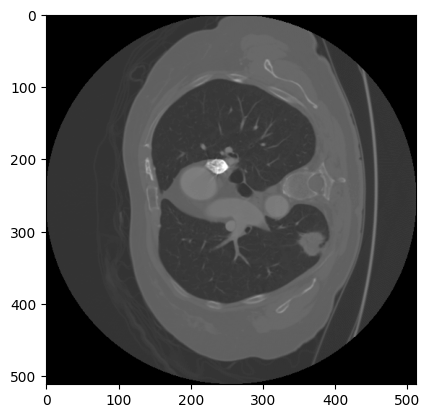

In [10]:
# ususally for extracting Lung, a window size of W=1200 and an offset L=-600 are used

img_gray = (images[0] - images[0].min())/(images[0].max() - images[0].min()) * 255

plt.imshow(img_gray, cmap='gray')
print(img_gray.min(), img_gray.max())

0.0 255.0


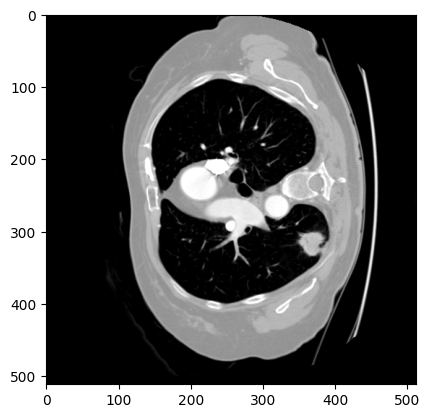

In [11]:
W = 1300
L = -220

v_min = L - W/2
v_max = L + W/2

img_window = np.clip(images[0], a_min=v_min, a_max=v_max)
img_rescaled = (img_window - v_min)/W * 255
plt.imshow(img_rescaled, cmap='gray')
print(img_rescaled.min(), img_rescaled.max())

In [12]:
benig_classed = [1, 2, 3]
malign_classes = [4, 5]

new_shape = (256, 256)
new_images = np.zeros((images.shape[0], new_shape[0], new_shape[1])) # [N, 224, 224] standard ResNet format
new_labels = np.zeros(images.shape[0]) - 1

W = 1300
L = -220

v_min = L - W/2
v_max = L + W/2

print(new_images.shape)
for i, im in enumerate(images.copy()):

    img_window = np.clip(im, a_min=v_min, a_max=v_max)
    img = (img_window - v_min)/W * 255
    
    
    img = cv2.resize(img, new_shape) # resize to new shape
    # img = np.stack((img, img, img), axis=-1)
    
    new_images[i] = img
    if (labels[i] in benig_classed):
        new_labels[i] = 0
    else:
        new_labels[i] = 1

new_labels = new_labels.astype(int)

(2363, 256, 256)


Range:  0.0 255.0
Label:  1


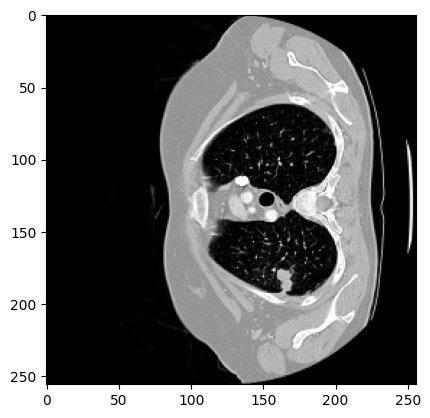

In [13]:
plt.imshow(new_images[189], cmap='gray')
print("Range: ", new_images[189].min(), new_images[189].max())
print("Label: ", new_labels[189])

Now we can see the class distribution

In [14]:
new_shape = (256, 256)
new_images_3channels = np.zeros((new_images.shape[0], new_shape[0], new_shape[1], 3)) # [N, 224, 224] standard ResNet format

for i, im in enumerate(new_images.copy()):
    img = np.stack((im, im, im), axis=-1)
    new_images_3channels[i] = img

Range:  0.0 255.0


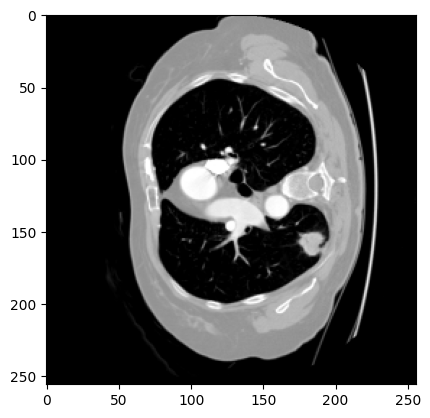

In [15]:
plt.imshow(new_images_3channels[0] / 255)
print("Range: ", new_images[0].min(), new_images[0].max())

### Splitting dataset into train - test

In [16]:
from sklearn.model_selection import train_test_split

X = new_images_3channels
y = new_labels

X_d, X_test, y_d, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_d, y_d, test_size=0.1, stratify=y_d, random_state=0)

# mean = X_train.mean()
# std = X_train.std()

# # normalizing according to the TRAIN mean and STD
# X_train = (X_train - mean)/std
# X_valid = (X_valid - mean)/std
# X_test = (X_test - mean)/std

print("Original dataset size:", X_train.shape, "Labels:", np.bincount(y_train))

Original dataset size: (1701, 256, 256, 3) Labels: [1291  410]


[0 1] [1291  410]


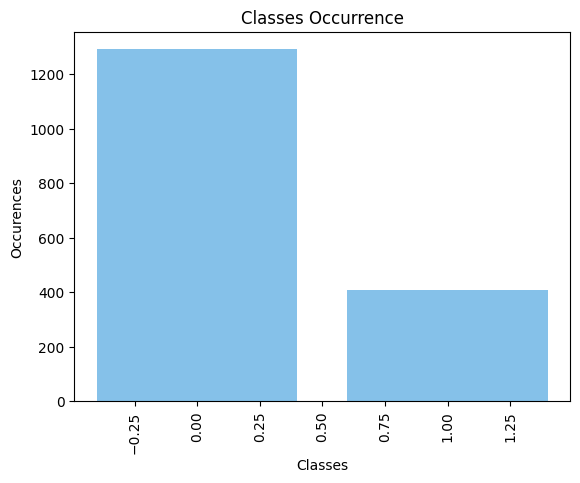

In [17]:
classes_names_bin, counts_bin = np.unique(y_train, return_counts=True)

print(classes_names_bin, counts_bin)

#for plotting we can use plt.bar function for example
plt.bar(x=classes_names_bin,height=counts_bin, facecolor ='#85c1e9')
plt.title("Classes Occurrence", color = "black")
plt.tick_params(axis="both", colors = "black")
plt.xlabel("Classes", color = "black")
plt.ylabel("Occurences", color = "black")
plt.xticks(rotation=90)
plt.yticks
plt.show()

In [18]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

Class weights: {0: 0.6587916343919442, 1: 2.074390243902439}


In [19]:
from sklearn.utils import resample
import numpy as np

# Assuming `images` (N, 224, 224, 3) and `labels` (N,)
# Separate indices for the two classes
class_0_indices = np.where(y_train == 0)[0]
class_1_indices = np.where(y_train == 1)[0]

# Identify the majority and minority classes
if len(class_0_indices) < len(class_1_indices):
    minority_class_indices = class_0_indices
    majority_class_indices = class_1_indices
else:
    minority_class_indices = class_1_indices
    majority_class_indices = class_0_indices

# Perform oversampling on the minority class
oversampled_minority_class_indices = resample(minority_class_indices,
                                              replace=True,               # Allow duplicates
                                              n_samples=len(majority_class_indices), # Match majority size
                                              random_state=42)            # For reproducibility

# Combine majority and oversampled minority class indices
balanced_indices = np.concatenate([majority_class_indices, oversampled_minority_class_indices])
np.random.shuffle(balanced_indices)  # Shuffle to randomize the dataset

# Create the balanced dataset
X_train_bal = X_train[balanced_indices]
y_train_bal = y_train[balanced_indices]

print("Balanced dataset size:", X_train_bal.shape, "Labels:", np.bincount(y_train_bal))

Balanced dataset size: (2582, 256, 256, 3) Labels: [1291 1291]


[0 1] [1291 1291]


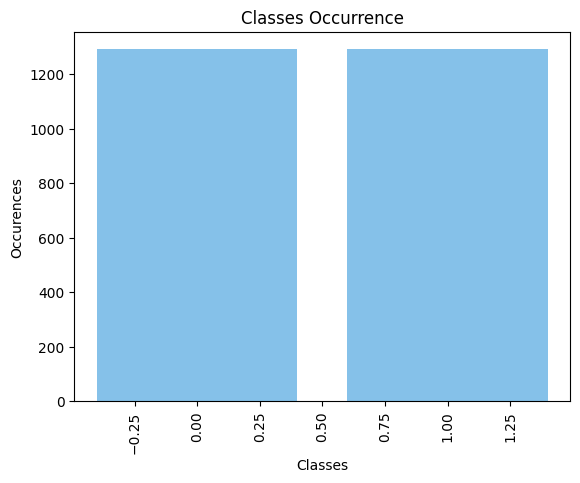

In [20]:
classes_names_bin, counts_bin = np.unique(y_train_bal, return_counts=True)

print(classes_names_bin, counts_bin)

#for plotting we can use plt.bar function for example
plt.bar(x=classes_names_bin,height=counts_bin, facecolor ='#85c1e9')
plt.title("Classes Occurrence", color = "black")
plt.tick_params(axis="both", colors = "black")
plt.xlabel("Classes", color = "black")
plt.ylabel("Occurences", color = "black")
plt.xticks(rotation=90)
plt.yticks
plt.show()

In [21]:
X_train = X_train_bal
y_train = y_train_bal

#### The dataset is highly unbalanced and we should balance it

### Add 3 channels for ResNet50

In [22]:
# import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2, ResNet50, InceptionV3, DenseNet121, EfficientNetV2S
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Concatenate, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint,Callback, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers, activations
from tensorflow.keras.applications.imagenet_utils import preprocess_input

train_data_generator = ImageDataGenerator(
                                    rescale=1/255,
                                    rotation_range=10,
                                    width_shift_range=0.01,
                                    height_shift_range=0.01,
                                    zoom_range=(0.95,1),
                                    brightness_range=(0.95,1.05))
                                    
validation_data_generator = ImageDataGenerator(rescale=1/255)
test_data_generator = ImageDataGenerator(rescale=1/255)

train_data_generator.fit(X_train)
validation_data_generator.fit(X_valid)
test_data_generator.fit(X_test)


# Generate batches of augmented data from numpy arrays
train_generator = train_data_generator.flow(
    x=X_train, y=y_train,
    batch_size=16,
    shuffle = True 
)

val_generator = validation_data_generator.flow(
    x=X_valid, y=y_valid,
    batch_size=16,
    shuffle = True
)

test_generator = validation_data_generator.flow(
    x=X_test, y=y_test,
    batch_size=16,
    shuffle = True
)

model_dir = "/kaggle/input/resnet50/tensorflow2/default/1/RadImageNet-ResNet50_notop.h5"
base_model = EfficientNetV2S(weights="imagenet", input_shape=(256, 256, 3), include_top=False)
# base_model.summary()

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Label:  0


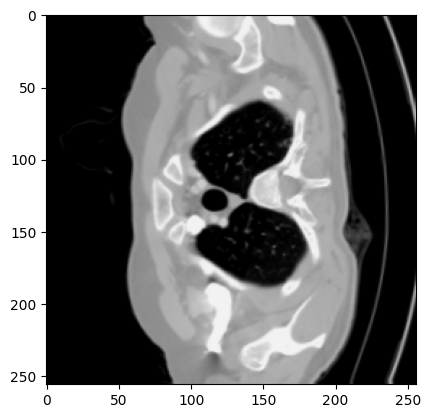

<Figure size 640x480 with 0 Axes>

Label:  1


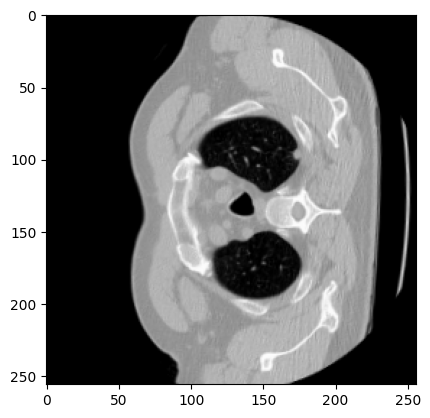

<Figure size 640x480 with 0 Axes>

Label:  1


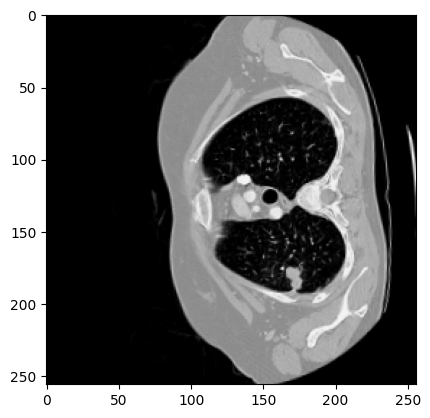

<Figure size 640x480 with 0 Axes>

Label:  1


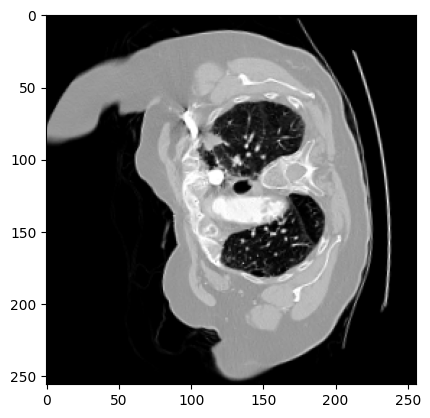

<Figure size 640x480 with 0 Axes>

Label:  1


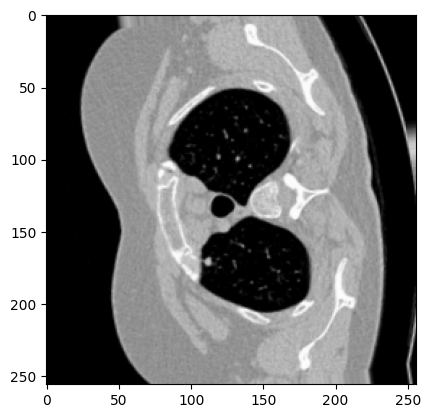

<Figure size 640x480 with 0 Axes>

Label:  0


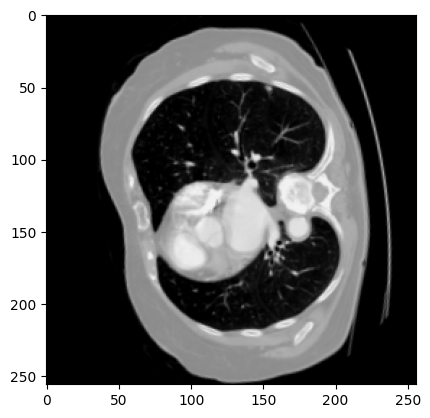

<Figure size 640x480 with 0 Axes>

Label:  0


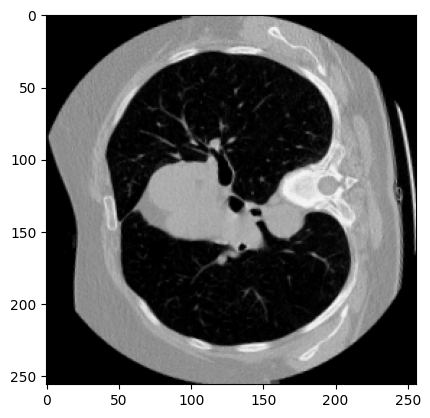

<Figure size 640x480 with 0 Axes>

Label:  1


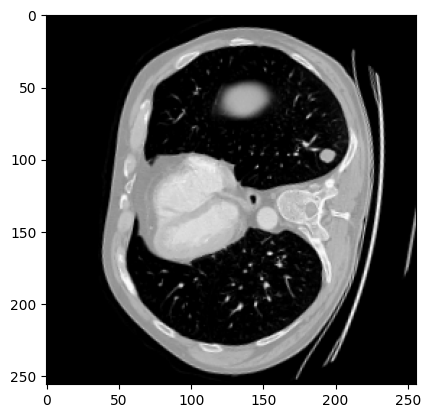

<Figure size 640x480 with 0 Axes>

Label:  0


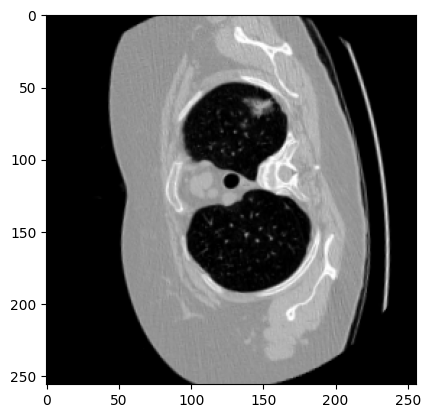

<Figure size 640x480 with 0 Axes>

Label:  1


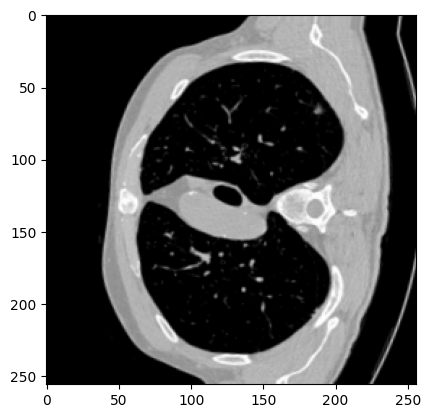

<Figure size 640x480 with 0 Axes>

Label:  1


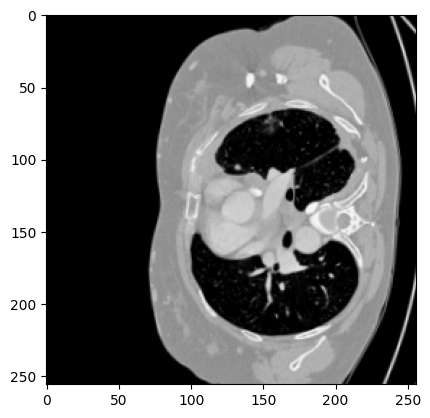

<Figure size 640x480 with 0 Axes>

Label:  1


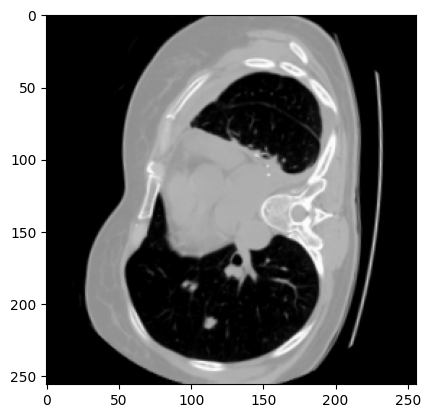

<Figure size 640x480 with 0 Axes>

Label:  1


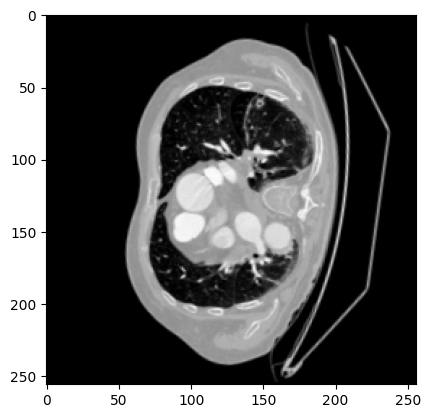

<Figure size 640x480 with 0 Axes>

Label:  1


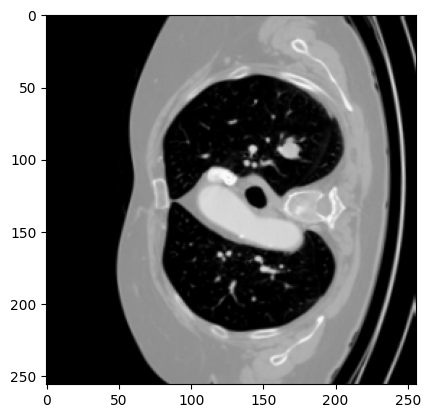

<Figure size 640x480 with 0 Axes>

Label:  0


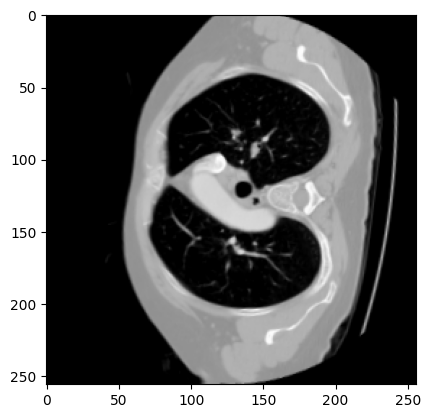

<Figure size 640x480 with 0 Axes>

Label:  1


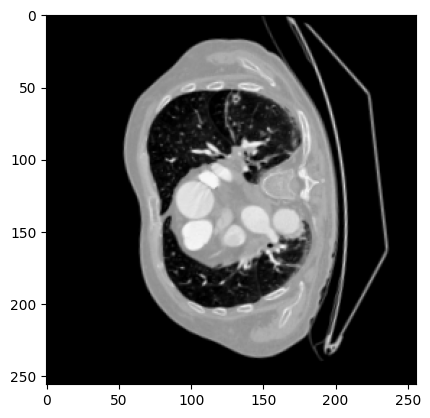

<Figure size 640x480 with 0 Axes>

In [23]:
batch = train_generator[0]
images = batch[0]
labels = batch[1]

for i in range(16):
    print("Label: ", labels[i])
    plt.imshow(images[i])
    plt.figure()
    # print("Range: ", images[i].min(), images[i].max())
    plt.show()

In [24]:
import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers as tfkl


# freeze all layers
base_model.trainable = True

# unfreeze 10
for layer in base_model.layers[-10:]:
    layer.trainable = True


# MODEL DEFINITION # 
inputs = tf.keras.Input(shape=(256, 256, 3), name='input_layer')

# inputs = tf.keras.applications.resnet.preprocess_input(inputs * 255)

# Connect resnet50 to the input
x = base_model(inputs)
# x = tfkl.Dropout(0.3, name='dropout1')(x)

x = tfkl.GlobalAveragePooling2D()(x)
x = tfkl.Dense(128, activation='relu', name='dense1', kernel_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.01))(x)
x = tfkl.Dropout(0.5, name='dropout3')(x)
x = tfkl.BatchNormalization(name='batchnorm1')(x)

# Output Layer - sigmoid binary classification
outputs = tfkl.Dense(1, name='dense2')(x)


# Create a Model connecting input and output
model = tfk.Model(inputs=inputs, outputs=outputs, name='model')


# Definizione dell'ottimizzatore Adam con learning rate di 10^-4
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Compila il modello con Adam
model.compile(
    loss=keras.losses.BinaryFocalCrossentropy(from_logits=True),  # Per output con softmax e label intere
    optimizer=adam_optimizer,
    metrics=['accuracy', 'AUC']
)

# Display model architecture with layer shapes and trainable parameters
# tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [25]:
model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 8, 8, 1280)     │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm1 (BatchNormalization) │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,495,969 (78.19 MB)

 Trainable params: 20,341,841 (77.60 MB)

 Non-trainable params: 154,128 (602.06 KB)

In [26]:
# Addestramento con i generatori
history = model.fit(
    train_generator,                      # Generatore per il training
    validation_data=(X_valid/255, y_valid),        # Generatore per la validazione
    epochs=100,                            # Numero di epoche (regola in base ai dati)
    class_weight=class_weights_dict,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=25, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, min_lr=1e-7)
    ])

model.save('best_model.h5')

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(history.history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1738775476.016021      70 service.cc:145] XLA service 0x7d02d0003940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738775476.016094      70 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1738775679.194039      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


162/162 ━━━━━━━━━━━━━━━━━━━━ 523s 1s/step - AUC: 0.5291 - accuracy: 0.5230 - loss: 475.4844 - val_AUC: 0.5404 - val_accuracy: 0.6402 - val_loss: 307.8189 - learning_rate: 1.0000e-04
Epoch 2/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 44s 258ms/step - AUC: 0.5726 - accuracy: 0.5597 - loss: 262.5159 - val_AUC: 0.5447 - val_accuracy: 0.6508 - val_loss: 143.1729 - learning_rate: 1.0000e-04
Epoch 3/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 43s 254ms/step - AUC: 0.6332 - accuracy: 0.6131 - loss: 113.5952 - val_AUC: 0.5284 - val_accuracy: 0.4762 - val_loss: 41.9681 - learning_rate: 1.0000e-04
Epoch 4/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 43s 252ms/step - AUC: 0.7153 - accuracy: 0.6605 - loss: 27.7350 - val_AUC: 0.6026 - val_accuracy: 0.2751 - val_loss: 2.1074 - learning_rate: 1.0000e-04
Epoch 5/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 42s 250ms/step - AUC: 0.7378 - accuracy: 0.6462 - loss: 0.9417 - val_AUC: 0.5571 - val_accuracy: 0.4392 - val_loss: 0.5974 - learning_rate: 1.0000e-04
Epoch 6/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 4

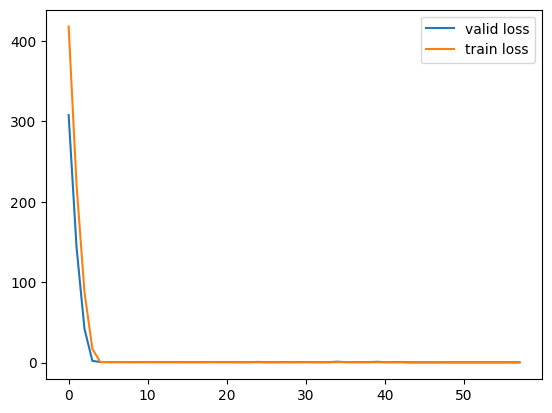

In [27]:
plt.plot(history.history['val_loss'], label='valid loss')
plt.plot(history.history['loss'], label='train loss')
plt.legend()

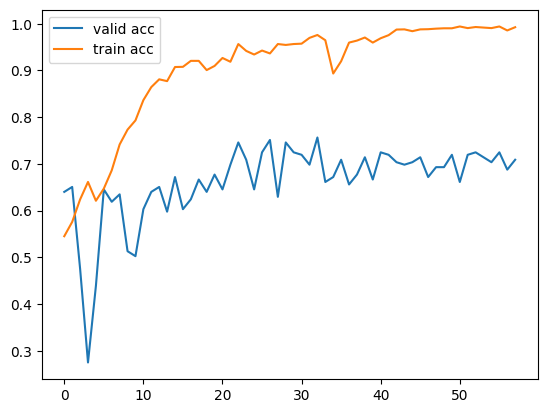

In [28]:
plt.plot(history.history['val_accuracy'], label='valid acc')
plt.plot(history.history['accuracy'], label='train acc')
plt.legend()

In [29]:
# Evaluate the model on the test set
test_loss, test_accuracy, test_auc = model.evaluate(X_test/255, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.2f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 508ms/step - AUC: 0.6551 - accuracy: 0.7562 - loss: 0.4578
Test Accuracy: 0.78
Test Loss: 0.42


In [30]:
print(1 - y_test.sum() / y_test.shape[0])

0.7589852008456659


In [31]:
from sklearn.metrics import roc_curve, confusion_matrix, auc

y_logits = model.predict(X_test/255).ravel()
fpr, tpr, thresholds_keras = roc_curve(y_test, tfk.activations.sigmoid(y_logits))
roc_auc = auc(fpr, tpr)

15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 624ms/step


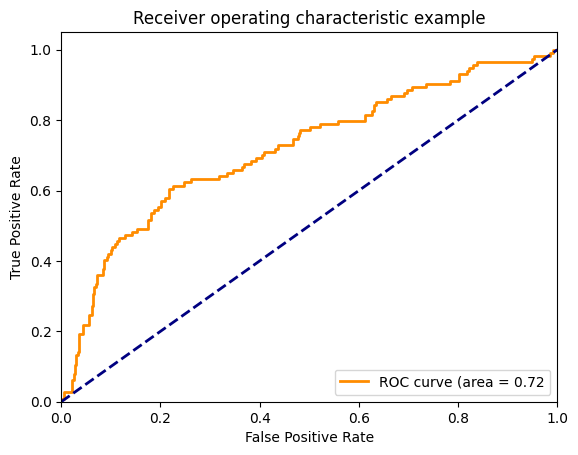

In [32]:
plt.plot(fpr, tpr,
            color="darkorange",
            lw=2,
            label=f"ROC curve (area = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

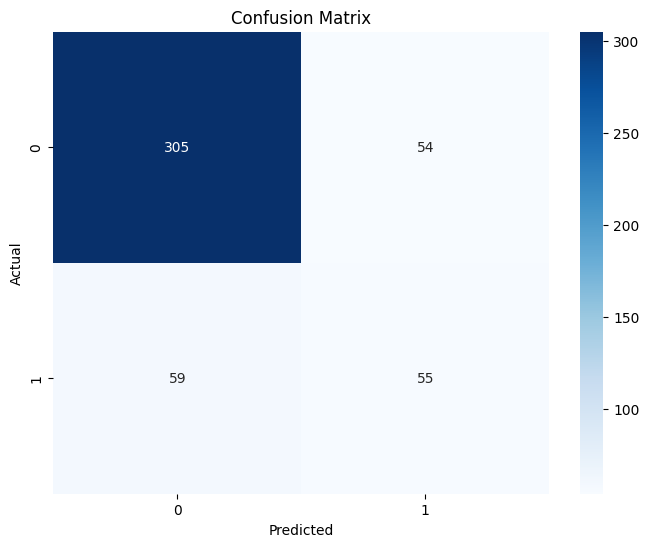

In [33]:
import seaborn as sns

conf_mat = confusion_matrix(y_test, tfk.activations.sigmoid(y_logits) >= 0.5)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')  
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Monte Carlo evaluation

In [34]:
class MCModel(tf.keras.Model):
    def call(self, inputs, training=True):  # Force training mode     
        return super().call(inputs, training=True)

In [35]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score

def compute_metric_ci_interval(metric):
    mean_metric = np.mean(metric, axis=0)
    std_metric = np.std(metric, axis=0)
    ci_lower = mean_metric - 1.96 * std_metric
    ci_upper = mean_metric + 1.96 * std_metric
    
    return mean_metric, ci_lower, ci_upper, std_metric

def compute_metrics(preds, labels):
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    
    cm = confusion_matrix(labels, preds)
    tp = cm[1, 1]
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    tnr = tn / (tn + fp)
    fnr = fn / (fn + tp)
    
    roc_auc = roc_auc_score(labels, preds)
    
    return accuracy, f1, precision, recall, roc_auc, fpr, tpr, tnr, fnr
    

def monte_carlo_simulation(model, X_test, y_test, n_simulations=100):
    
    test_probs = []
    test_labels = []
    test_preds = []
    
    test_acc = []
    test_f1 = []
    test_precision = []
    test_recall = []
    test_auc = []
    test_fpr = []
    test_tpr = []
    test_tnr = []
    test_fnr = []
    
    for i in range(n_simulations):

        print("Training ", i)

        logits = model.predict(X_test/255)
        
        probs = keras.activations.sigmoid(logits)
        preds = probs >= 0.5
        
        test_probs.append(probs)
        test_preds.append(preds)
        
        accuracy, f1, precision, recall, auc_score, fpr, tpr, tnr, fnr = compute_metrics(preds, y_test)
        
        test_acc.append(accuracy)
        test_f1.append(f1)
        test_precision.append(precision)
        test_recall.append(recall)
        test_auc.append(auc_score)
        test_fpr.append(fpr)
        test_tpr.append(tpr)
        test_tnr.append(tnr)
        test_fnr.append(fnr)
    
    return test_probs, test_labels, (test_acc, test_f1, test_precision, test_recall, test_auc, test_fpr, test_tpr, test_tnr, test_fnr)

In [36]:
best_model_path = '/kaggle/input/best_model_challeng_applied_ai/keras/default/1/best_model.h5'
# model = keras.models.load_model(best_model_path)
model.trainable = False
model.get_layer('dropout3').trainable= True
model = MCModel(inputs=model.input, outputs=model.output)

In [37]:
from sklearn.metrics import roc_curve, confusion_matrix, auc

y_logits = model.predict(X_test/255).ravel()
fpr, tpr, thresholds_keras = roc_curve(y_test, tfk.activations.sigmoid(y_logits))
roc_auc = auc(fpr, tpr)

15/15 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step


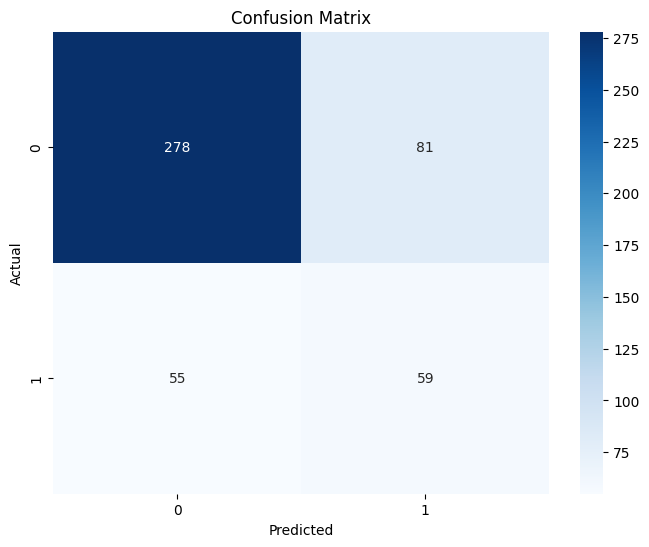

In [38]:
import seaborn as sns

conf_mat = confusion_matrix(y_test, tfk.activations.sigmoid(y_logits) >= 0.5)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')  
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

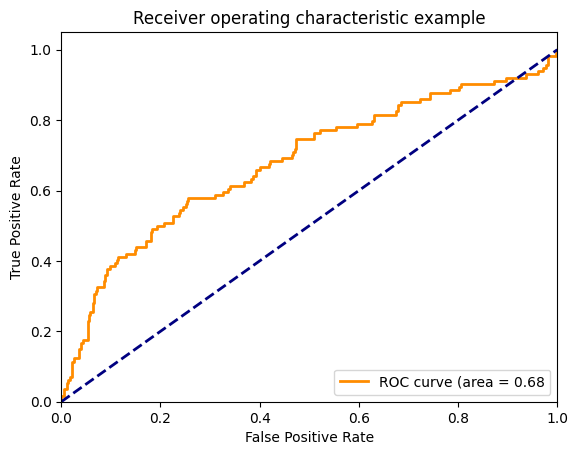

In [39]:
plt.plot(fpr, tpr,
            color="darkorange",
            lw=2,
            label=f"ROC curve (area = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [40]:
test_probs, test_labels, metrics = monte_carlo_simulation(model, X_test, y_test, n_simulations=50)

Training  0
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
Training  1
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Training  2
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Training  3
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Training  4
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Training  5
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Training  6
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Training  7
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Training  8
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Training  9
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Training  10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Training  11
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Training  12
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Training  13
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Training  14
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Training  15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Training  16
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Training  17
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Training  18
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Tra

test_acc: 0.73 +- 0.02 (95% CI: 0.70, 0.75) - 0.01
test_f1: 0.48 +- 0.03 (95% CI: 0.44, 0.51) - 0.02
test_precision: 0.44 +- 0.03 (95% CI: 0.41, 0.48) - 0.02
test_recall: 0.52 +- 0.05 (95% CI: 0.47, 0.57) - 0.02
test_auc: 0.66 +- 0.02 (95% CI: 0.63, 0.68) - 0.01
test_fpr: 0.21 +- 0.03 (95% CI: 0.18, 0.24) - 0.01
test_tpr: 0.52 +- 0.05 (95% CI: 0.47, 0.57) - 0.02
test_tnr: 0.79 +- 0.03 (95% CI: 0.76, 0.82) - 0.01
test_fnr: 0.48 +- 0.05 (95% CI: 0.43, 0.53) - 0.02


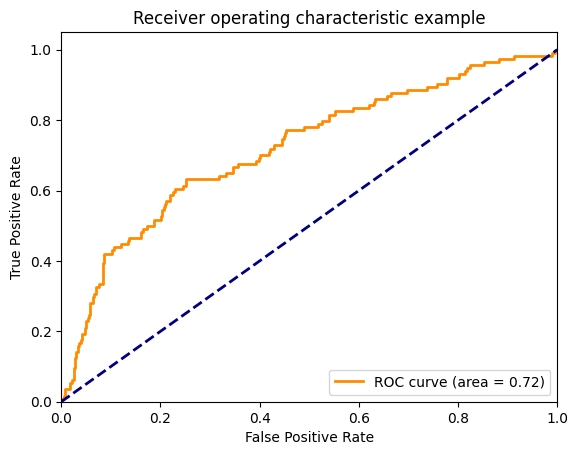

In [41]:
mean_probs = np.stack(test_probs).mean(axis=0)
std_probs = np.stack(test_probs).std(axis=0)

metric_name = ['test_acc', 'test_f1', 'test_precision', 'test_recall', 'test_auc', 'test_fpr', 'test_tpr','test_tnr', 'test_fnr']
for i, metric in enumerate(metrics):
    mean_metric, ci_lower, ci_upper, std = compute_metric_ci_interval(metric)
    print(f"{metric_name[i]}: {mean_metric:.2f} +- {1.96 * std:.2f} (95% CI: {ci_lower:.2f}, {ci_upper:.2f}) - {std:.2f}")
    
fpr, tpr, thresholds = roc_curve(y_test, mean_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
        lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()